Data: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

* Lower the wscss (within cluster sum of squares) the better it is, it calculates the compactness of the cluster
* Silhouette Score measures how well-separated the clusters are,
higher the Silhouette score means better clustering.
* Elbow method point is the one where wcss does not change rapidly.
* PCA you want the variance to be captured to be around 80%.
* For eps parameter, choose the distance metric on the graph where there is a sudden rise
* Lower the values of AIC, BIC better the model is. The optimal values are the ones where there is a bend.
*

##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.neighbors import NearestNeighbors

##Read Data & Data Cleaning

In [39]:
df = pd.read_csv('/content/marketing_campaign.csv.xls',sep='\t')
df_copy = df.copy()
df.shape

(2240, 29)

In [40]:
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0


In [41]:
# df.head()

# df.to_csv('sample_data.csv',index=False)

# income_median = df.groupby(['Education', 'Marital_Status'])['Income'].median().reset_index()
# income_median

# df_copy.isnull().sum()

# df['Education'].unique()

# df['Marital_Status'].unique()

# df_copy['Marital_Status'].value_counts()

In [43]:
df_copy['Total_children'] = df_copy['Kidhome'] + df_copy['Teenhome']
df_copy['MntAllFood'] = df_copy['MntFruits'] + df_copy['MntMeatProducts'] + df_copy['MntFishProducts'] + df_copy['MntSweetProducts']
df_copy['NumPurchases'] = df_copy['NumWebPurchases'] + df_copy['NumStorePurchases'] + df_copy['NumCatalogPurchases']

df_copy = df_copy[~df_copy['Marital_Status'].isin(['Alone','Absurd', 'YOLO'])]

df_copy['Income'] = df_copy.groupby(['Education', 'Marital_Status'])['Income'].transform(lambda x: x.fillna(x.median()))

education_mapping = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
df_copy['Education'] = df_copy['Education'].map(education_mapping)

# df_copy = pd.get_dummies(df_copy, columns=['Marital_Status'], drop_first=True)
df_copy = pd.get_dummies(df_copy, columns=['Marital_Status'])

columns_to_convert = ['Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single',
                      'Marital_Status_Together', 'Marital_Status_Widow']
df_copy[columns_to_convert] = df_copy[columns_to_convert].replace({True: 1, False: 0})

df_copy['Dt_Customer'] = pd.to_datetime(df_copy['Dt_Customer'], format='%d-%m-%Y')
df_copy['Days_Till_Today'] = (pd.to_datetime('today') - df_copy['Dt_Customer']).dt.days

df_copy['Year_Birth'] = pd.to_datetime(df_copy['Year_Birth'], format='%Y')
df_copy['Age'] = pd.to_datetime('today').year - df_copy['Year_Birth'].dt.year

In [44]:
df_scaled_raw = df_copy.copy()

In [45]:
num_cols = ['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Days_Till_Today', 'Age','Total_children','MntAllFood','NumPurchases']

scaler = StandardScaler()
# df_copy_scaled = scaler.fit_transform(df_copy)
df_scaled_raw[num_cols] = scaler.fit_transform(df_scaled_raw[num_cols])

In [46]:
df_scaled = df_scaled_raw.drop(['ID', 'Year_Birth','Dt_Customer','Z_CostContact', 'Z_Revenue'], axis=1)

In [47]:
corr_matrix = df_scaled.corr()
corr_matrix

# sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Credit Score Feature Correlation Matrix", fontsize=0.1)
# plt.show()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_children,MntAllFood,NumPurchases,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Days_Till_Today,Age
Education,1.000000,0.150196,-0.053411,0.132969,-0.012439,0.214890,-0.073671,0.044845,-0.099572,-0.092032,-0.093145,0.034529,0.098277,0.088406,0.093638,-0.057289,0.001347,0.058496,0.037462,-0.002756,0.024242,-0.044466,0.097122,0.058077,-0.006479,0.115939,0.014202,0.004742,-0.023784,-0.010900,0.043333,-0.063315,0.185272
Income,0.150196,1.000000,-0.424979,0.019772,-0.005364,0.576815,0.428232,0.577373,0.437367,0.436013,0.320766,-0.081499,0.381162,0.586516,0.526750,-0.549535,-0.014886,0.182419,0.334307,0.273928,0.087670,-0.027164,0.133287,-0.290101,0.605015,0.622224,0.008230,-0.015910,-0.026189,0.023335,0.031589,-0.019768,0.161488
Kidhome,-0.053411,-0.424979,1.000000,-0.036654,0.008674,-0.496564,-0.372176,-0.437136,-0.387375,-0.371070,-0.348971,0.222382,-0.362769,-0.502173,-0.499576,0.448396,0.012930,-0.161861,-0.205117,-0.171661,-0.081837,0.040251,-0.079694,0.689777,-0.479361,-0.568698,-0.019259,0.017371,0.019766,0.006331,-0.073879,-0.051395,-0.231090
Teenhome,0.132969,0.019772,-0.036654,1.000000,0.017387,0.004641,-0.175268,-0.260538,-0.201949,-0.161907,-0.019243,0.387473,0.154300,-0.109216,0.051130,0.132839,-0.044320,0.039049,-0.190158,-0.138946,-0.015582,0.003178,-0.156225,0.698252,-0.266923,0.038248,0.052819,0.008065,-0.095896,0.025307,0.045226,0.016254,0.352232
Recency,-0.012439,-0.005364,0.008674,0.017387,1.000000,0.015507,-0.005860,0.021870,-0.000565,0.021407,0.015896,0.001596,-0.009428,0.023366,0.000315,-0.019462,-0.033027,0.018239,-0.001009,-0.020509,-0.002038,0.013040,-0.198307,0.018810,0.017773,0.005979,0.003700,-0.024545,0.006033,0.019117,-0.000193,0.025247,0.018848
MntWines,0.214890,0.576815,-0.496564,0.004641,0.015507,1.000000,0.389796,0.563280,0.401224,0.386592,0.388495,0.010935,0.542329,0.635971,0.641923,-0.321499,0.063817,0.373441,0.473318,0.354521,0.205983,-0.039056,0.248638,-0.352343,0.577134,0.756320,0.021035,-0.010738,-0.024391,0.004910,0.036598,0.164988,0.157665
MntFruits,-0.073671,0.428232,-0.372176,-0.175268,-0.005860,0.389796,1.000000,0.543087,0.593576,0.567206,0.390749,-0.130890,0.298755,0.486289,0.461837,-0.416787,0.015942,0.010177,0.213501,0.192205,-0.009783,-0.005171,0.125155,-0.393586,0.697482,0.520574,0.009639,-0.011306,0.007032,-0.014163,0.032265,0.066783,0.018829
MntMeatProducts,0.044845,0.577373,-0.437136,-0.260538,0.021870,0.563280,0.543087,1.000000,0.569113,0.524427,0.351037,-0.121840,0.295549,0.724777,0.479785,-0.539437,0.019355,0.102810,0.375324,0.311225,0.042988,-0.023574,0.238962,-0.501897,0.959351,0.624078,-0.025492,-0.022626,0.034747,0.002597,0.018555,0.093531,0.029628
MntFishProducts,-0.099572,0.437367,-0.387375,-0.201949,-0.000565,0.401224,0.593576,0.569113,1.000000,0.581886,0.417971,-0.138438,0.297245,0.532599,0.461211,-0.443629,0.001835,0.017342,0.195979,0.257378,0.002761,-0.020907,0.110425,-0.423804,0.737284,0.538474,-0.015021,-0.030119,0.007415,0.016821,0.048398,0.081348,0.043237
MntSweetProducts,-0.092032,0.436013,-0.371070,-0.161907,0.021407,0.386592,0.567206,0.524427,0.581886,1.000000,0.370665,-0.118873,0.350203,0.490794,0.448730,-0.423269,0.002275,0.028348,0.258782,0.240978,0.009863,-0.022605,0.117914,-0.383113,0.684108,0.536296,-0.002385,-0.007826,0.001952,-0.014137,0.054457,0.081061,0.018921


##Model Data

In [48]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

In [49]:
pca_full = PCA(n_components=0.8)  # Keep 80% of variance
df_pca_full = pca_full.fit_transform(df_scaled)
print(f"Total Components Used: {pca_full.n_components_}")

Total Components Used: 15


##KMeans Clustering

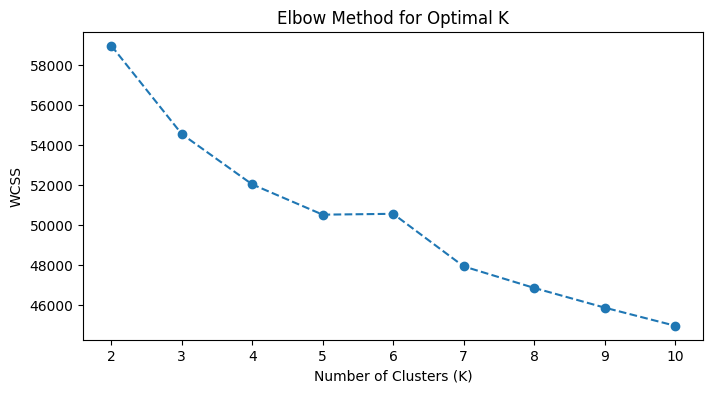

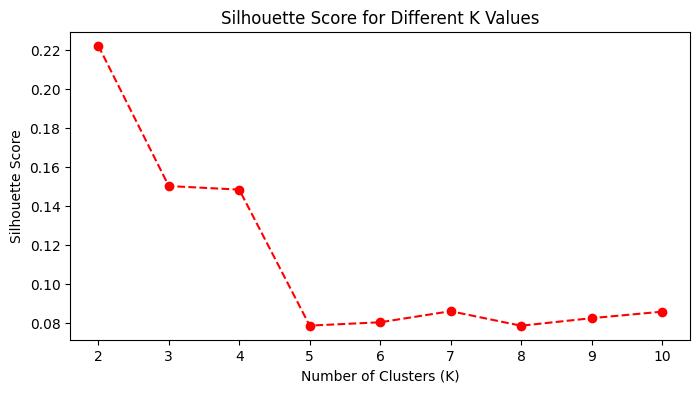

In [50]:
wcss = []
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled) #Better to run on the original data

    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, labels))

# Plot Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), sil_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.show()

In [51]:
optimal_k_km = 4

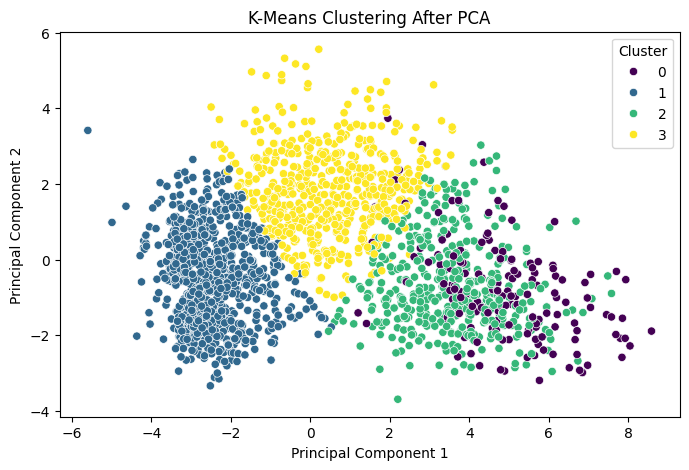

Explained Variance by PC1: 0.26, PC2: 0.08


In [52]:
kmeans_pca = KMeans(n_clusters=optimal_k_km, random_state=42)
# df_copy['Cluster'] = kmeans_pca.fit_predict(df_pca) # This is better when we just want to visualize the clusters
df_copy['Cluster'] = kmeans_pca.fit_predict(df_scaled) # This is better when we want to do cluster analysis

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_copy['Cluster'], palette="viridis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering After PCA")
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f}")

In [53]:
silhouette_km = silhouette_score(df_scaled, df_copy['Cluster'])
print(f"Silhouette Score: {silhouette_km:.3f}")

Silhouette Score: 0.148


In [54]:
df_copy['Cluster'].value_counts()

,count
Cluster,
1,1042
3,582
2,443
0,166


##Agglomerative Clustering

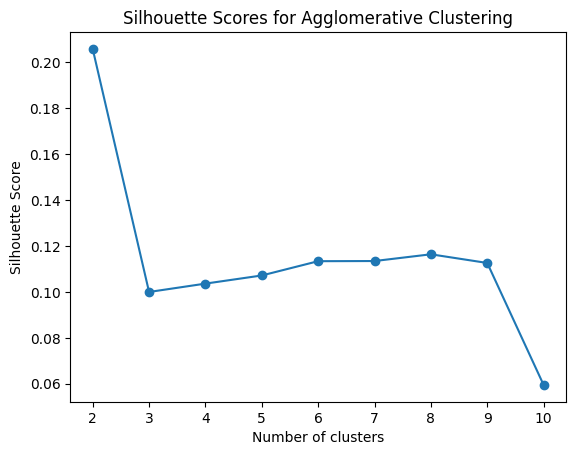

In [55]:
sil_scores = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(df_scaled)
    sil_scores.append(silhouette_score(df_scaled, labels))

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [56]:
optimal_k_agg = 6

In [57]:
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k_agg, linkage="ward")
df_copy["Cluster_Agg"] = agg_clustering.fit_predict(df_scaled)

sil_score_agg = silhouette_score(df_scaled, df_copy["Cluster_Agg"])
db_score_agg = davies_bouldin_score(df_scaled, df_copy["Cluster_Agg"])

print(f"Agglomerative Clustering Results:")
print(f"Silhouette Score: {sil_score_agg:.4f}")
print(f"Davies-Bouldin Score: {db_score_agg:.4f}")

Agglomerative Clustering Results:
Silhouette Score: 0.1134
Davies-Bouldin Score: 2.3283


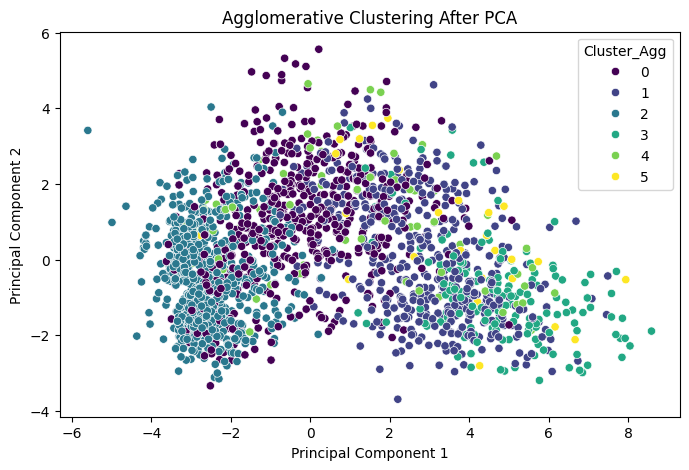

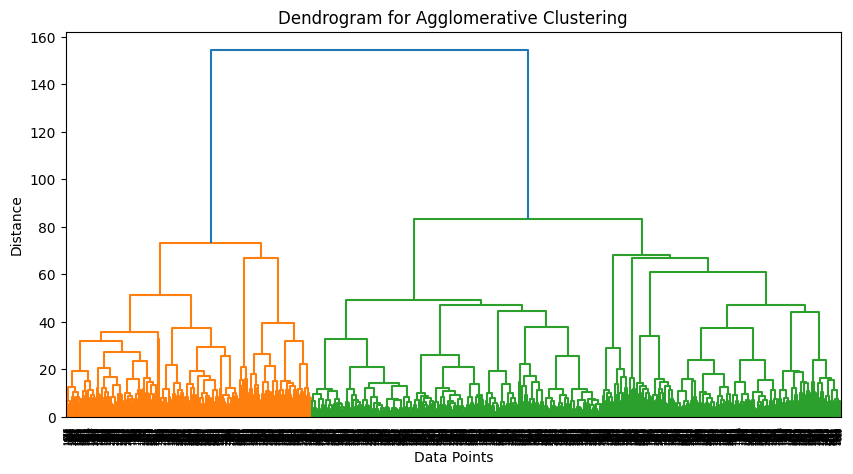

In [58]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_copy["Cluster_Agg"], palette="viridis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Agglomerative Clustering After PCA")
plt.show()

plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(df_scaled, method="ward"))
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [59]:
df_copy["Cluster_Agg"].value_counts()

,count
Cluster_Agg,
2,839
0,611
1,500
3,178
4,75
5,30


##DBSCAN Clustering

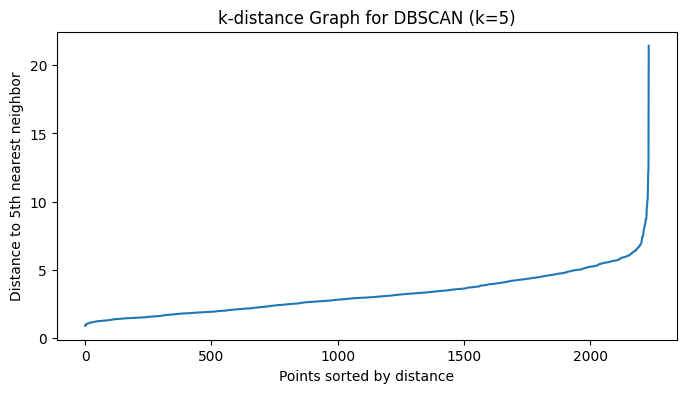

In [61]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Sort distances to find "elbow"
distances = np.sort(distances[:, 4])  # 4th neighbor
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (k=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 5th nearest neighbor")
plt.show()

In [62]:
# Use PCA or scaled data depending on what you want to evaluate
X = df_scaled  # or

best_score = -1
best_params = None

eps_values = np.arange(5.0, 7.6, 0.25)
# eps_values = [2,3,4]
min_samples_values = range(5, 10)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            score = silhouette_score(X, labels)
            print(f"eps: {eps}, min_samples: {min_samples}, clusters: {n_clusters}, silhouette: {score:.3f}")

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
        else:
            print(f"eps: {eps}, min_samples: {min_samples}, Not enough clusters (only {n_clusters})")

print("\nBest Parameters:")
print(f"eps: {best_params[0]}, min_samples: {best_params[1]}, Silhouette Score: {best_score:.3f}")

eps: 5.0, min_samples: 5, clusters: 5, silhouette: 0.152
eps: 5.0, min_samples: 6, clusters: 4, silhouette: 0.154
eps: 5.0, min_samples: 7, clusters: 4, silhouette: 0.145
eps: 5.0, min_samples: 8, clusters: 3, silhouette: 0.173
eps: 5.0, min_samples: 9, clusters: 3, silhouette: 0.169
eps: 5.25, min_samples: 5, clusters: 5, silhouette: 0.163
eps: 5.25, min_samples: 6, clusters: 3, silhouette: 0.183
eps: 5.25, min_samples: 7, clusters: 3, silhouette: 0.183
eps: 5.25, min_samples: 8, clusters: 3, silhouette: 0.184
eps: 5.25, min_samples: 9, clusters: 4, silhouette: 0.153
eps: 5.5, min_samples: 5, clusters: 5, silhouette: 0.173
eps: 5.5, min_samples: 6, clusters: 3, silhouette: 0.195
eps: 5.5, min_samples: 7, clusters: 3, silhouette: 0.195
eps: 5.5, min_samples: 8, clusters: 3, silhouette: 0.195
eps: 5.5, min_samples: 9, clusters: 3, silhouette: 0.195
eps: 5.75, min_samples: 5, clusters: 5, silhouette: 0.202
eps: 5.75, min_samples: 6, clusters: 4, silhouette: 0.198
eps: 5.75, min_samples: 

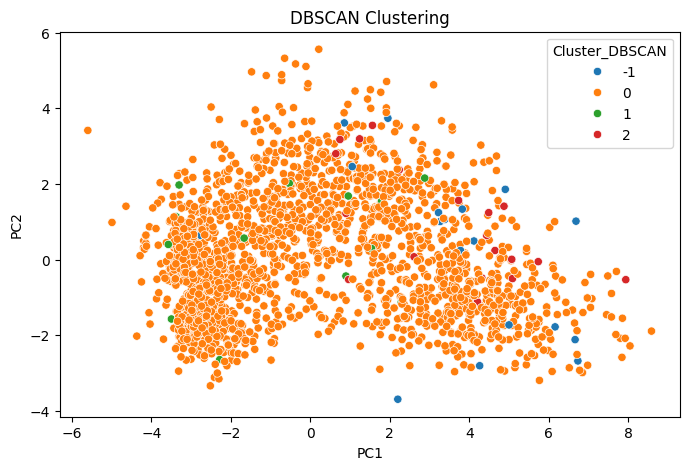

In [63]:
dbscan = DBSCAN(eps=7.5, min_samples=5)
df_copy['Cluster_DBSCAN'] = dbscan.fit_predict(df_scaled)  # or df_copy_scaled, depending on your preference

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_copy['Cluster_DBSCAN'], palette='tab10')
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [64]:
df_copy['Cluster_DBSCAN'].value_counts()

,count
Cluster_DBSCAN,
0,2172
2,22
1,20
-1,19


##Gaussian Mixture

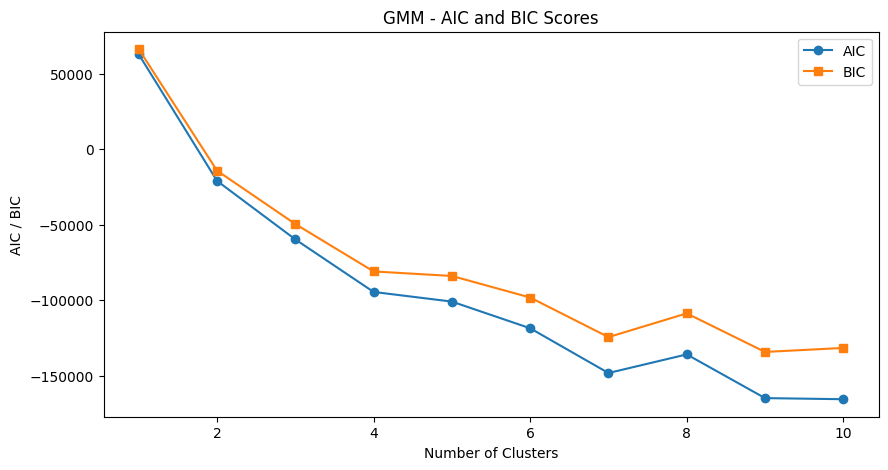

In [65]:
aic = []
bic = []

for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_scaled)
    aic.append(gmm.aic(df_scaled))
    bic.append(gmm.bic(df_scaled))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), aic, label='AIC', marker='o')
plt.plot(range(1, 11), bic, label='BIC', marker='s')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC / BIC')
plt.title('GMM - AIC and BIC Scores')
plt.legend()
plt.show()

In [66]:
optimal_k_gmm = 4

Gaussian Mixture Model Clustering Results:
Silhouette Score: 0.0574
Davies-Bouldin Score: 2.9200


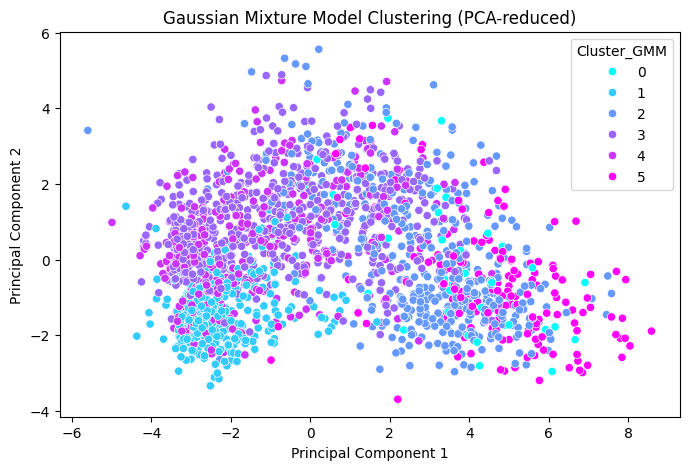

In [67]:
# GMM Clustering
gmm = GaussianMixture(n_components=6, random_state=42)
df_copy['Cluster_GMM'] = gmm.fit_predict(df_scaled)

# Evaluate
sil_score_gmm = silhouette_score(df_scaled, df_copy['Cluster_GMM'])
db_score_gmm = davies_bouldin_score(df_scaled, df_copy['Cluster_GMM'])

print(f"Gaussian Mixture Model Clustering Results:")
print(f"Silhouette Score: {sil_score_gmm:.4f}")
print(f"Davies-Bouldin Score: {db_score_gmm:.4f}")

# PCA Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_copy['Cluster_GMM'], palette="cool")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Gaussian Mixture Model Clustering (PCA-reduced)")
plt.show()


In [68]:
df_copy['Cluster_GMM'].value_counts()

,count
Cluster_GMM,
3,688
2,462
1,448
4,424
5,170
0,41


##HDBSCAN

In [69]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
labels = clusterer.fit_predict(df_scaled)

df_copy['Cluster_HDBSCAN'] = labels
print(pd.Series(labels).value_counts())

# Optional: silhouette score
from sklearn.metrics import silhouette_score
if len(set(labels)) > 1 and -1 in labels:
    print("Silhouette Score:", silhouette_score(df_scaled[labels != -1], labels[labels != -1]))


 3    1967
-1     171
 2      53
 1      22
 0      20
Name: count, dtype: int64
Silhouette Score: 0.201184692469942


##Cluster Analysis

In [70]:
df_copy.head(1)

,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Total_children,MntAllFood,NumPurchases,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Days_Till_Today,Age,Cluster,Cluster_Agg,Cluster_DBSCAN,Cluster_GMM,Cluster_HDBSCAN
0,5524,1957-01-01,2,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,0,894,22,0,0,1,0,0,4600,68,2,1,0,2,3


In [71]:
df_copy.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Total_children',
       'MntAllFood', 'NumPurchases', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'Days_Till_Today',
       'Age', 'Cluster', 'Cluster_Agg', 'Cluster_DBSCAN', 'Cluster_GMM',
       'Cluster_HDBSCAN'],
      dtype='object')

In [72]:
cols = ['Income','Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth','AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain','Response', 'Total_children',
       'MntAllFood', 'NumPurchases','Days_Till_Today',
       'Age']

# print("\n📊 Cluster Profiling:")
cluster_profile = df_copy.groupby('Cluster')[cols].mean()

# Optional: Add cluster size
cluster_profile['Count'] = df_copy['Cluster'].value_counts().sort_index()
print(cluster_profile)

               Income    Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster                                                                    
0        81787.698795  49.427711  874.716867  56.590361       470.891566   
1        35183.136756  49.486564   42.166987   4.991363        23.359885   
2        74070.637698  49.584650  492.530474  72.081264       435.595937   
3        57689.908935  48.223368  466.623711  20.967354       133.481100   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
Cluster                                                                       
0              77.313253         66.469880     77.391566           1.036145   
1               7.023033          4.992322     15.488484           2.054702   
2             105.568849         71.257336     77.013544           1.478555   
3              28.687285         21.872852     60.022337           3.805842   

         NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \


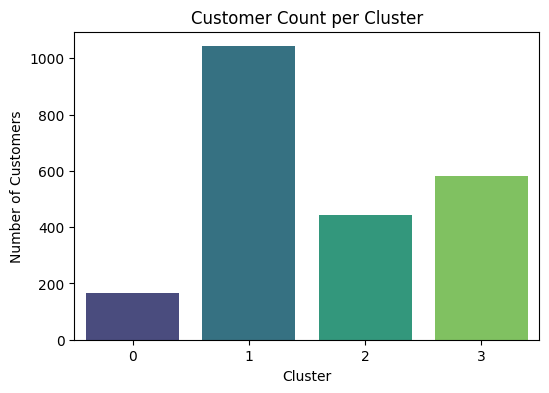

In [73]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_copy, x='Cluster', palette='viridis')
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

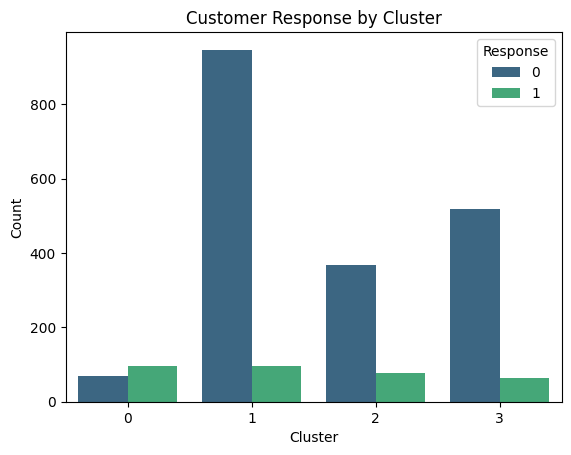

In [84]:
sns.countplot(data=df_copy, x='Cluster', hue='Response', palette='viridis')
plt.title("Customer Response by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Response")
plt.show()

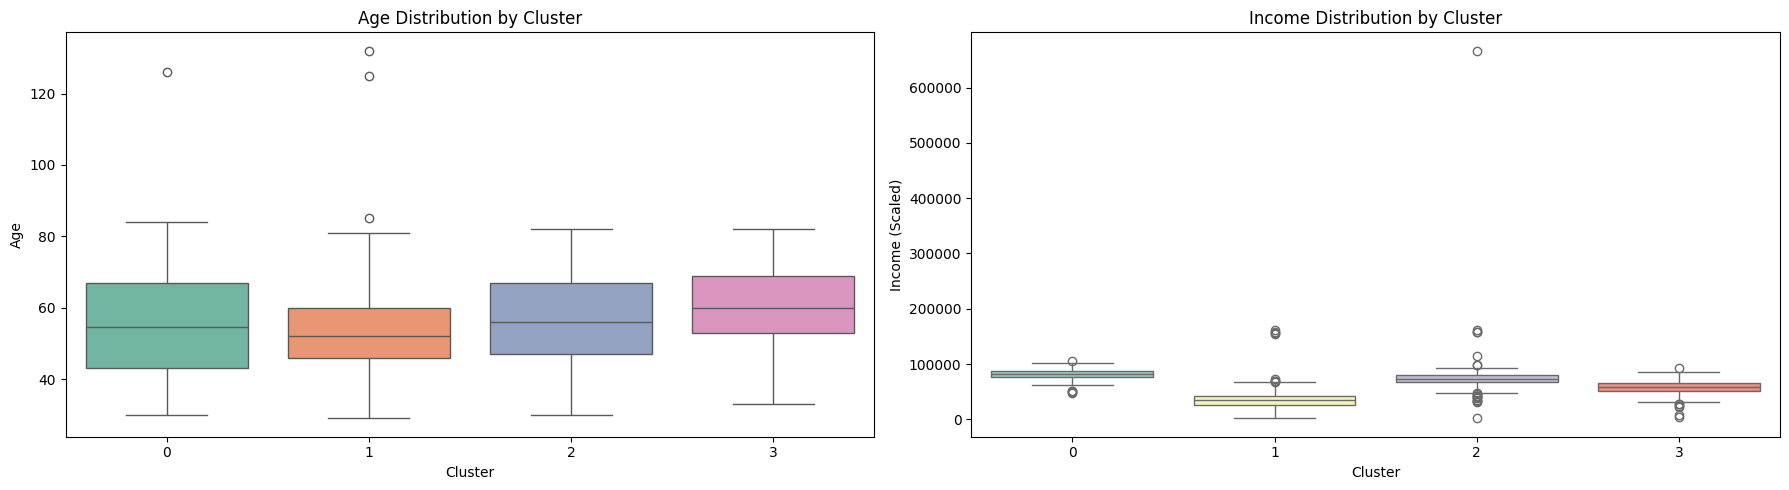

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Age distribution by cluster
sns.boxplot(data=df_copy, x='Cluster', y='Age', palette='Set2', ax=axes[0])
axes[0].set_title("Age Distribution by Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Age")

# Income distribution by cluster
sns.boxplot(data=df_copy, x='Cluster', y='Income', palette='Set3', ax=axes[1])
axes[1].set_title("Income Distribution by Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Income (Scaled)")

plt.tight_layout()
plt.show()
